# Output Analysis

In [1]:
from tensorflow.keras.models import model_from_json
from sklearn.metrics         import roc_curve, auc
import numpy          as np
import tensorflow     as tf
import pandas         as pd
from glob import glob as glb
np.warnings.filterwarnings('ignore')

import json

from TopTagger.ensemble.DataGenerator import DataGenerator
from TopTagger.CovNet.utils           import get_correlations, get_error_correlations

import matplotlib.pyplot as plt
from matplotlib.colors   import LogNorm, Normalize
plt.rcParams['xtick.direction']           = 'in'
plt.rcParams['ytick.direction']           = 'in'
plt.rcParams['xtick.top']                 = True
plt.rcParams['xtick.minor.visible']       = True
plt.rcParams['ytick.right']               = True
plt.rcParams['ytick.minor.visible']       = True
plt.rcParams['xtick.labelsize']           = 15
plt.rcParams['ytick.labelsize']           = 15
plt.rcParams['axes.labelsize']            = 20

Prepare the test data for both RNN and CNN-type networks

In [2]:
path = 'EnsembleNN/samples_v2'
train_dict = {'image': {'bkg' : glb(path+'/train/QCD_CovNet_*'),
                        'sig' : glb(path+'/train/tt_CovNet_*')},
              'lstm' : {'bkg' : glb(path+'/train/QCD_LSTM_*'),
                        'sig' : glb(path+'/train/tt_LSTM_*')}}
test_dict   = {'image': {'bkg' : glb(path+'/test/QCD_CovNet_*'),
                         'sig' : glb(path+'/test/tt_CovNet_*')},
               'lstm' : {'bkg' : glb(path+'/test/QCD_LSTM_*'),
                         'sig' : glb(path+'/test/tt_LSTM_*')}}
def srt(x):
    return int(x.split('_')[-1].split('.')[0])

for dc in [train_dict,test_dict]:
    dc['image']['bkg'].sort(key=srt)
    dc['image']['sig'].sort(key=srt)
    dc['lstm' ]['bkg'].sort(key=srt)
    dc['lstm' ]['sig'].sort(key=srt)

normalize_meanstd = lambda x : x/1000.

class lstm_std:
    def __init__(self,train_dict):
        from sklearn.preprocessing import RobustScaler 
        X = np.zeros(40)
        i=0
        while X.shape[0]<100000 and i<len(train_dict['lstm']['sig']):
            sig, bkg = list(zip(train_dict['lstm']['sig'],train_dict['lstm']['bkg']))[i]
            sig = np.load(sig)['sample']
            bkg = np.load(bkg)['sample']
            X = np.vstack((X,sig))
            X = np.vstack((X,bkg))
            i+=1
        X = X[1:]
        np.random.shuffle(X)
        self.transformer = RobustScaler().fit(X)#
    def __call__(self,X):
        return self.transformer.transform(X)

lstm_std = lstm_std(train_dict)

#train = DataGenerator(train_dict,batch_size=128, std=[normalize_meanstd,lstm_std])
test  = DataGenerator(test_dict,batch_size=5000, shuffle=False, std=[normalize_meanstd,lstm_std])

In [3]:
test.sample_size

404000

Function to plot correlations

In [18]:
def plot_correlations(correlations, extent, title='', img_dim=(37, 37), name='corr.png'):
    """
    call the function about and then plot the correlations in image format
    """
    max_mag = max(
        abs(np.min(correlations[np.isfinite(correlations)])),
        abs(np.max(correlations[np.isfinite(correlations)])),
    ) # highest correlation value (abs value), to make the plot look nice and on a reasonable scale

    fig = plt.figure(1, figsize=(8, 6), facecolor='w', edgecolor='k')
    sys = fig.add_subplot(111)
    im = sys.imshow(
        correlations.reshape(img_dim),
        interpolation='gaussian',
        norm=Normalize(vmin=np.min(correlations[np.isfinite(correlations)]), vmax=max_mag),
        extent=extent,
        cmap=plt.cm.seismic
    )
    cbar = plt.colorbar(im)
    cbar.set_label(r"Correlation Magnitude", fontsize=20)
    #plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel("$\eta^\prime$",fontsize=20)
    plt.ylabel("$\phi^\prime$",fontsize=20)
    plt.xlim([-.7,.7])
    plt.ylim([-.7,.7])
    if name == '':
        plt.show()
    else:
        plt.savefig(name, bbox_inches = 'tight')

Get CNN predictions

In [23]:
test.Reset()
test.batch_size = 50000
X_test, y_test  = test[0]

In [49]:
main_path = 'EnsembleNN/'
with open(main_path+'output/covnet/Model_4/covnet_model.json','r') as f:
    model = model_from_json(json.load(f))
model.load_weights(main_path+'output/covnet/Model_4/covnet_model.h5')

yhat_cov = model.predict(X_test[0],verbose=True)

313/313 [==============================] - 2s 5ms/step


Get RNN predictions

In [50]:
with open(main_path+'output/lstm/Model_7/model.json','r') as f:
    model = model_from_json(json.load(f))
model.load_weights(main_path+'output/lstm/Model_7/lstm_model.h5')

yhat_rnn = model.predict(X_test[1],verbose=True)

313/313 [==============================] - 3s 9ms/step


Get mean prediction

In [51]:
mean_pred = np.hstack((yhat_rnn, yhat_cov)).mean(axis=1).reshape(yhat_cov.shape)

Get ENN predictions

In [24]:
enn_path = main_path+'output/enn/SingleConv96_0'
files    = glb(enn_path+'/*')
model_json = [x for x in files if 'model' in x and 'json' in x][0]
with open([x for x in files if 'model' in x and 'json' in x][0],'r') as f:
    model = model_from_json(json.load(f))
model.load_weights([x for x in files if 'h5' in x][0])

yhat_enn = model.predict(X_test,verbose=True)

1563/1563 [==============================] - 18s 12ms/step


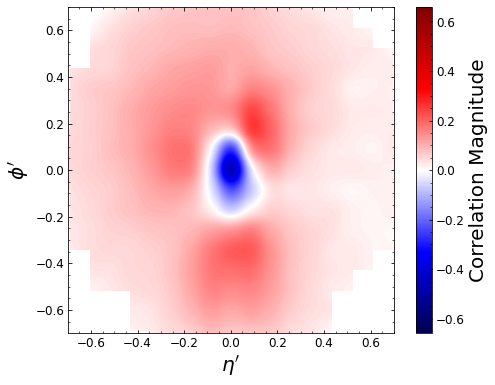

In [7]:
corr = get_correlations(X_test[0],yhat_cov)
plot_correlations(corr, [-1.6,1.6,-1.6,1.6], title='', img_dim=(37, 37), name='')

Plot error vs kinematics 

In [21]:
def plot_output_vs_kin(x_data, 
                       y_test,
                       yhat,
                       xlabel,
                       ylabel, 
                       cbar_label=r"Classifier Output",
                       cmap='rainbow',
                       nbins=30,
                       xlim=[],
                       v = [],
                       save='',
                       title=[]):
    # set the colormap
    #plt.set_cmap('jet')
    # draw a 2d histogram of the discriminator's output versus the kinematic variable of choice (mass, pT, etc.)
    h, binx, biny = np.histogram2d(x_data, yhat.reshape(-1,), bins=nbins,weights=(y_test-yhat.reshape(-1,))**2)
    
    # normalize the histogram such that the entries in each column add up to 1, such that the intensity
    # of each corresponds to the percentage of the jets in a given mass (or pT) bin that get assigned a p
    for i in range(nbins):
        h[i, :] = h[i, :] / float(np.sum(h[i, :]))
    # plot the normalized histogram as an image
    lognorm = LogNorm()
    if v != []:
        lognorm = LogNorm(vmin=v[0],vmax=v[1])
        
    fig = plt.figure(1, figsize=(8, 6), facecolor='w', edgecolor='k')
    sys = fig.add_subplot(111)
    im = sys.imshow(#h.T,
        np.flipud(h.T), 
        interpolation='nearest',
        norm=lognorm,
        extent=[binx.min(), binx.max(), biny.min(), biny.max()],
        aspect="auto",
        cmap=cmap
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim != []:
        sys.set_xlim(xlim)
    sys.set_ylim([0,1])
    cbar = plt.colorbar(im)
    cbar.set_label(cbar_label, fontsize=20)
    if title!=[]:
        plt.text(title[0],title[1],title[2],color='darkred',fontsize=15)
    if save=='':
        plt.show()
    else:
        plt.savefig(save, bbox_inches = 'tight')

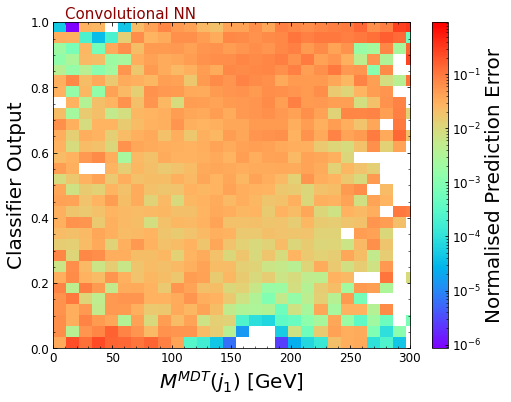

In [11]:
plot_output_vs_kin(lstm_std.transformer.inverse_transform(X_test[1].reshape(X_test[1].shape[0],X_test[1].shape[1]))[:,1],
                   y_test, yhat_cov,
                   '$M^{MDT}(j_1)$ [GeV]', 
                   r'Classifier Output', 
                   nbins=30,
                   cbar_label=r'Normalised Prediction Error',xlim=[0,300],v=[],cmap='rainbow',
                   save='cnn_MDT_pred.png', title = [10,1.01,'Convolutional NN'])

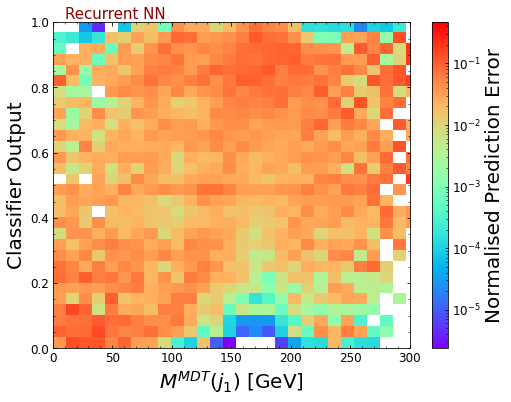

In [12]:
plot_output_vs_kin(lstm_std.transformer.inverse_transform(X_test[1].reshape(X_test[1].shape[0],X_test[1].shape[1]))[:,1],
                   y_test, yhat_rnn,
                   '$M^{MDT}(j_1)$ [GeV]', 
                   r'Classifier Output', 
                   nbins=30,
                   cbar_label=r'Normalised Prediction Error',xlim=[0,300],
                   save='rnn_MDT_pred.png', title = [10,1.01,'Recurrent NN'])

In [26]:
plot_output_vs_kin(lstm_std.transformer.inverse_transform(X_test[1].reshape(X_test[1].shape[0],X_test[1].shape[1]))[:,1],
                   y_test, yhat_enn,
                   '$M^{MDT}(j_1)$ [GeV]', 
                   r'Classifier Output', 
                   nbins=30,
                   cbar_label=r'Normalised Prediction Error',xlim=[0,300],
                   save='enn_MDT_pred.png', title = [10,1.01,'Ensemble NN'])

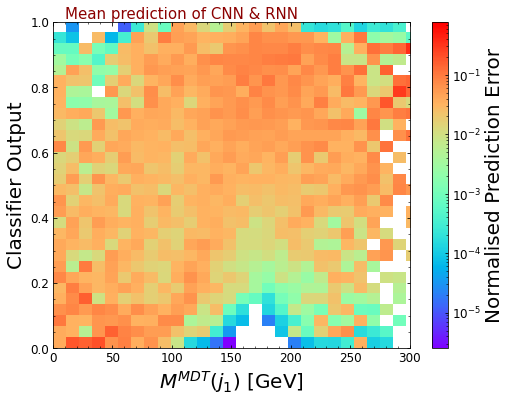

In [20]:
plot_output_vs_kin(lstm_std.transformer.inverse_transform(X_test[1].reshape(X_test[1].shape[0],X_test[1].shape[1]))[:,1],
                   y_test, mean_pred,
                   '$M^{MDT}(j_1)$ [GeV]', 
                   r'Classifier Output', 
                   nbins=30,
                   cbar_label=r'Normalised Prediction Error',xlim=[0,300],
                   save='mean_MDT_pred.png', title = [10,1.01,'Mean prediction of CNN & RNN'])

# Correlations

In [27]:
def get_error_correlations(images, yhat, ytrue):
    """
    calculate linear correlation between each pixel and the output of the classifier
    to see what pixels are more indicative of a specific class.
    """
    import pandas as pd
    # -- find the total number of pixels per image, here 25 x 25
    n_pixels = np.prod(images.shape[1:3])
    
    # -- add the pixels as columns to a dataframe
    df = pd.DataFrame(
        {i : np.squeeze(images).reshape(-1, n_pixels)[:, i] for i in range(n_pixels)}
    )
    # -- add a column to the end of the dataframe for the discriminator's output
    ytrue = ytrue.reshape(yhat.shape)
    df['disc_output'] = (ytrue - yhat)**2
    # -- pandas offers an easy solution to calculate correlations 
    # (even though it's slow because it also calculates the correlation between each pixel and every other pixel)
    correlations = df.corr().values[:-1, -1]
    return correlations

def plot_correlations(correlations, extent, title=[], img_dim=(37, 37), name='corr.png',cbar_label=r"Correlation Magnitude"):
    """
    call the function about and then plot the correlations in image format
    """
    max_mag = max(
        abs(np.min(correlations[np.isfinite(correlations)])),
        abs(np.max(correlations[np.isfinite(correlations)])),
    ) # highest correlation value (abs value), to make the plot look nice and on a reasonable scale

    fig = plt.figure(1, figsize=(8, 6), facecolor='w', edgecolor='k')
    sys = fig.add_subplot(111)
    im = sys.imshow(
        correlations.reshape(img_dim),
        interpolation='gaussian',
        norm=Normalize(vmin=-0.2, vmax=0.2),
        extent=extent,
        cmap=plt.cm.seismic
    )
    cbar = plt.colorbar(im)
    cbar.set_label(cbar_label, fontsize=20)
    #plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel("$\eta^\prime$",fontsize=20)
    plt.ylabel("$\phi^\prime$",fontsize=20)
    plt.xlim([-.7,.7])
    plt.ylim([-.7,.7])
    if title!=[]:
        plt.text(title[0],title[1],title[2],color='darkred',fontsize=15)
    if name == '':
        plt.show()
    else:
        plt.savefig(name, bbox_inches = 'tight')

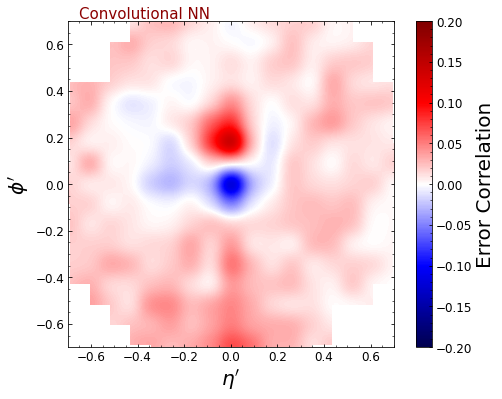

In [58]:
corr = get_error_correlations(X_test[0], yhat_cov, y_test)
plot_correlations(corr, extent=[-1.6,1.6,-1.6,1.6], 
                  title=[-.65,.71,'Convolutional NN'], 
                  img_dim=(37, 37),cbar_label='Error Correlation',name='cnn_errcorr.png')

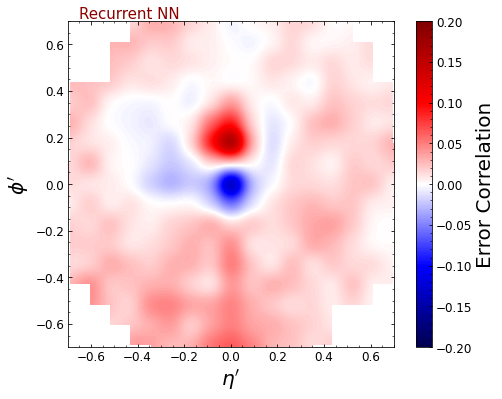

In [59]:
corr = get_error_correlations(X_test[0], yhat_rnn, y_test)
plot_correlations(corr, extent=[-1.6,1.6,-1.6,1.6], 
                  title = [-.65,.71,'Recurrent NN'],
                  img_dim=(37, 37), name='rnn_errcorr.png',cbar_label='Error Correlation')

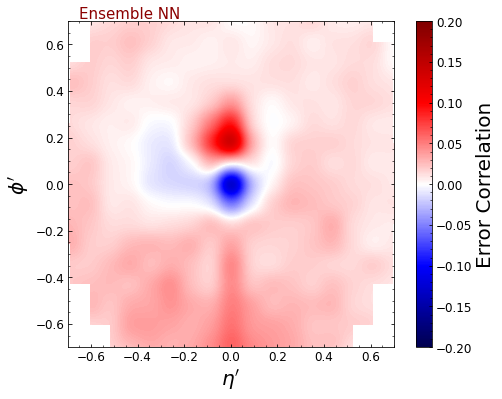

In [28]:
corr = get_error_correlations(X_test[0], yhat_enn, y_test)
plot_correlations(corr, extent=[-1.6,1.6,-1.6,1.6], 
                  title = [-.65,.71,'Ensemble NN'],
                  img_dim=(37, 37), name='enn_errcorr.png',cbar_label='Error Correlation')

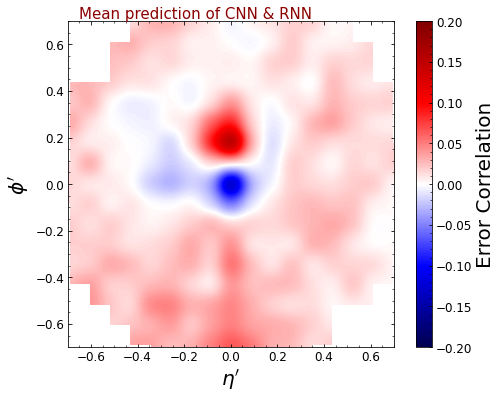

In [61]:
corr = get_error_correlations(X_test[0], mean_pred, y_test)
plot_correlations(corr, extent=[-1.6,1.6,-1.6,1.6], 
                  title = [-.65,.71,'Mean prediction of CNN & RNN'],
                  img_dim=(37, 37), name='mean_errcorr.png',cbar_label='Error Correlation')

# ROC

In [6]:
def get_roc(roc, name=''):
    tpr = []
    fpr = []
    auc = []
    acc = []
    prec = []
    mse = []
    for key, item in roc.items():
        if 'tpr' in key:
            tpr.append(np.array(item))
        elif 'fpr' in key:
            fpr.append(np.array(item))
        elif 'auc' in key:
            auc.append(np.array(item))
        elif 'accuracy' in key:
            acc.append(item)
        elif 'precision' in key:
            prec.append(item)
        elif 'mse' in key:
            mse.append(item)

    if name !='':
        print(name+' Accuracy  = $ {:.5f} \pm {:.5f} $'.format(np.mean(acc),np.std(acc)))
        print(name+' MSE       = $ {:.5f} \pm {:.5f} $'.format(np.mean(mse),np.std(mse)))
        print(name+' Precision = $ {:.5f} \pm {:.5f} $'.format(np.mean(prec),np.std(prec)))
        print('='*10)
    
    tpr = np.array(tpr)
    fpr = np.array(fpr)
    auc = np.array(auc)
    
    min_size = min([x.shape[0] for x in tpr])
    new_tpr = []
    for i in tpr:
        new_tpr.append(i[len(i)-min_size:])
    new_tpr = np.array(new_tpr).T

    min_size = min([x.shape[0] for x in fpr])
    new_fpr = []
    for i in fpr:
        new_fpr.append(i[len(i)-min_size:])
    new_fpr = np.array(new_fpr).T
    return new_tpr,new_fpr,auc

with open('EnsembleNN/output/lstm/Model_7/roc.json') as f:
    lstm_roc = json.load(f)
with open('EnsembleNN/output/covnet/Model_4/covnet_roc.json') as f:
    covnet_roc = json.load(f)
with open('EnsembleNN/output/enn/SingleConv96_0/roc.json') as f: #SingleConv96_0
    enn_roc = json.load(f)
with open('EnsembleNN/output/enn/ENN_2Layer_0/roc.json') as f: #SingleConv96_0
    enn_roc_test = json.load(f)

lstm_tpr, lstm_fpr, lstm_auc       = get_roc(lstm_roc,'RNN')
covnet_tpr, covnet_fpr, covnet_auc = get_roc(covnet_roc,'CNN')
enn_tpr, enn_fpr, enn_auc          = get_roc(enn_roc,'ENN')

RNN Accuracy  = $ 0.92170 \pm 0.00106 $
RNN MSE       = $ 0.05805 \pm 0.00072 $
RNN Precision = $ 0.90531 \pm 0.00160 $
CNN Accuracy  = $ 0.92740 \pm 0.00071 $
CNN MSE       = $ 0.05382 \pm 0.00062 $
CNN Precision = $ 0.90812 \pm 0.00193 $
ENN Accuracy  = $ 0.93024 \pm 0.00069 $
ENN MSE       = $ 0.05158 \pm 0.00040 $
ENN Precision = $ 0.91702 \pm 0.00125 $


In [4]:
from sklearn.metrics         import roc_curve, auc

main_path = 'EnsembleNN/'
with open(main_path+'output/covnet/Model_4/covnet_model.json','r') as f:
    model_cnn = model_from_json(json.load(f))
model_cnn.load_weights(main_path+'output/covnet/Model_4/covnet_model.h5')

with open(main_path+'output/lstm/Model_7/model.json','r') as f:
    model_rnn = model_from_json(json.load(f))
model_rnn.load_weights(main_path+'output/lstm/Model_7/lstm_model.h5')


roc_dict= {}
test.Reset()
test.batch_size = 50000

acc, mse, precision = [], [], []

for ix in range(len(test)):
    print('Iteration ',ix)
    X_test, y_test = test[ix]
    yhat_cnn = model_cnn(X_test[0], training=False)
    yhat_rnn = model_rnn(X_test[1], training=False)
    mean_pred = np.hstack((yhat_rnn, yhat_cnn)).mean(axis=1)

    accuracy         = tf.keras.metrics.BinaryAccuracy()
    MeanSquaredError = tf.keras.metrics.MeanSquaredError()
    Precision        = tf.keras.metrics.Precision()
    
    acc.append(accuracy(y_test,mean_pred).numpy())
    mse.append(MeanSquaredError(y_test,mean_pred).numpy())
    precision.append(Precision(y_test,mean_pred).numpy())
    
    fpr, tpr, tresholds = roc_curve(y_test, mean_pred,pos_label=1, 
                                    drop_intermediate=False)
    roc_auc = auc(fpr, tpr)

    roc_dict['tpr_'+str(ix)] = tpr.tolist() if type(tpr)==np.ndarray else tpr
    roc_dict['fpr_'+str(ix)] = fpr.tolist() if type(fpr)==np.ndarray else fpr
    roc_dict['tresholds_'+str(ix)] = tresholds.tolist() if type(tresholds)==np.ndarray else tresholds
    roc_dict['auc'+str(ix)] = float(roc_auc)

mean_tpr, mean_fpr, mean_pred_auc = get_roc(roc_dict)
print('Accuracy  = $ {:.4f} \pm {:.4f} $'.format(np.mean(acc),np.std(acc)))
print('MSE       = $ {:.4f} \pm {:.4f} $'.format(np.mean(mse),np.std(mse)))
print('Precision = $ {:.4f} \pm {:.4f} $'.format(np.mean(precision),np.std(precision)))

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Accuracy  = $ 0.9282 \pm 0.0011 $
MSE       = $ 0.0532 \pm 0.0007 $
Precision = $ 0.9068 \pm 0.0017 $


RNN 441.26245442646973
CNN 427.17162448837274
Mean 709.2198581560284
ENN 757.4018629864838


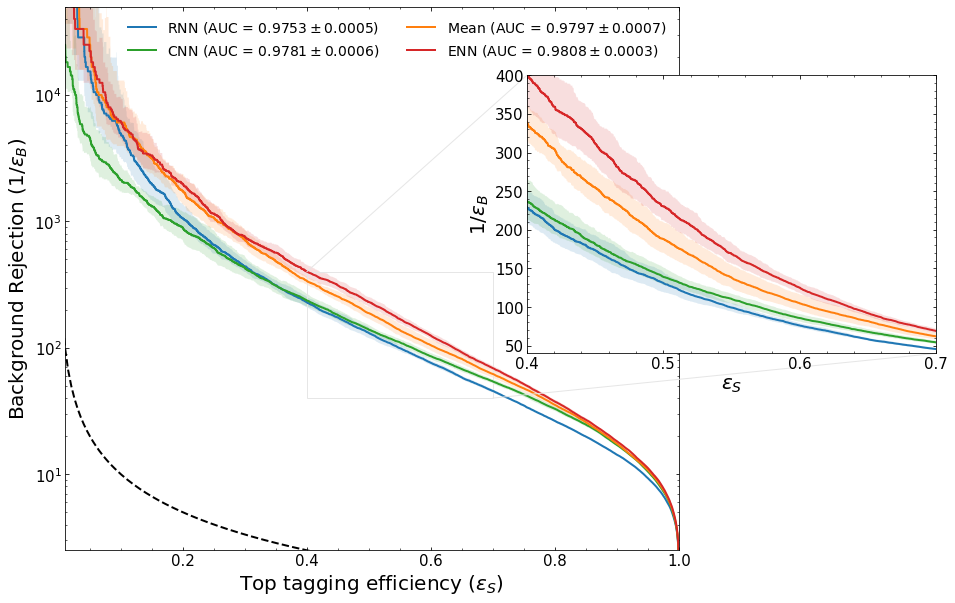

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = plt.figure(figsize=(11, 10), facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

to_plot = [
           (lstm_tpr, lstm_fpr, lstm_auc,       'RNN', 'tab:blue'),
           #(lstm_tpr_new, lstm_fpr_new, lstm_auc_new,       'RNN new ', 'tab:orange'),
           (covnet_tpr, covnet_fpr, covnet_auc, 'CNN', 'tab:green'),
           (mean_tpr, mean_fpr, mean_pred_auc,  'Mean','tab:orange'),
           (enn_tpr, enn_fpr, enn_auc,          'ENN', 'tab:red'),
           #(enn_tpr_test, enn_fpr_test, enn_auc_test,          'ENN test', 'tab:purple')
           ]

axins = zoomed_inset_axes(ax, 2.2,bbox_to_anchor=(975,570))
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=".9",capstyle='round')


for tpr, fpr, auc, name, color in to_plot:
    
    tpr_mean = tpr.mean(axis=1)
    tpr_std  = 1.*tpr.std(axis=1)
    fpr_mean = fpr.mean(axis=1)
    fpr_std  = 1.*fpr.std(axis=1)
    
    if 'ENN' in name:
        enn_mean5 = (1./fpr_mean[np.isclose(tpr_mean,[0.5],rtol=.0001)==True]).max()
        enn_mean8 = (1./fpr_mean[np.isclose(tpr_mean,[0.8],rtol=.0001)==True]).max()
    elif 'CNN' in name:
        cnn_mean5 = (1./fpr_mean[np.isclose(tpr_mean,[0.5],rtol=.0001)==True]).max()
        cnn_mean8 = (1./fpr_mean[np.isclose(tpr_mean,[0.8],rtol=.0001)==True]).max()
    elif 'RNN' in name:
        rnn_mean5 = (1./fpr_mean[np.isclose(tpr_mean,[0.5],rtol=.0001)==True]).max()
        rnn_mean8 = (1./fpr_mean[np.isclose(tpr_mean,[0.8],rtol=.0001)==True]).max()
    elif 'Mean' in name:
        ave_mean5 = (1./fpr_mean[np.isclose(tpr_mean,[0.5],rtol=.0001)==True]).max()
        ave_mean8 = (1./fpr_mean[np.isclose(tpr_mean,[0.8],rtol=.0001)==True]).max()
    
    print(name,(1./fpr_mean[np.isclose(tpr_mean,[0.3],rtol=.0001)==True]).max())
    
    unc = '{:.3f}' if auc.std() > 0.001 else '{:.4f}'
    ax.plot(tpr_mean,np.where(fpr_mean>0,1./fpr_mean,1./min([x for x in fpr_mean if x>0])),
             lw=2, label=name+' (AUC = $'+unc.format(auc.mean())+'\pm'+unc.format(auc.std())+'$)',
             color=color) 

    ax.fill_between(tpr_mean, np.where((fpr_mean-fpr_std)>0.,1./(fpr_mean-fpr_std),1./min([x for x in (fpr_mean-fpr_std) if x>0])),
                     np.where((fpr_mean+fpr_std)>0,1./(fpr_mean+fpr_std),1./min([x for x in (fpr_mean+fpr_std) if x>0])),color=color,
                     alpha=0.15,lw=0)#color='#888888', 

    axins.plot(tpr_mean,np.where(fpr_mean>0,1./fpr_mean,1./min([x for x in fpr_mean if x>0])),
             lw=2, color=color) 
    axins.fill_between(tpr_mean, np.where((fpr_mean-fpr_std)>0.,1./(fpr_mean-fpr_std),1./min([x for x in (fpr_mean-fpr_std) if x>0])),
                     np.where((fpr_mean+fpr_std)>0,1./(fpr_mean+fpr_std),1./min([x for x in (fpr_mean+fpr_std) if x>0])),color=color,
                     alpha=0.15,lw=0)


#axins.set_xlim(.5, .8) 
#axins.set_ylim(20, 230)
axins.set_xlim(.4, .7) 
axins.set_ylim(40, 400)
#axins.set_xticks([0.5,0.6,0.7,0.8])
axins.set_xticks([0.4,0.5,0.6,.7])
axins.yaxis.set_ticks_position('both')
axins.set_xlabel('$\epsilon_S$')
axins.set_ylabel('$1/\epsilon_B$')

x = np.linspace(min([x for x in fpr_mean if x>0]),1.,200)
ax.plot(x, 1./x, 'k--', lw=2)

#ax.plot([0.5,.5],[5,3e2],linestyle='dashed',color='darkred',zorder=0)
#ax.plot([0.8,.8],[1.8e1,3e3],linestyle='dashed',color='darkred',zorder=0)

#plt.text(0.51,1.2e1,'$\epsilon_S = 0.5$',fontsize=15,color='darkred',rotation=90)
#ax.text(0.28,8e1,  r'$1/\epsilon^{ENN}_B'+' = {:.0f}$'.format(enn_mean5),fontsize=15,color='darkred')
#ax.text(0.27,3.25e1,  r'$1/\epsilon^{Mean}_B'+' = {:.0f}$'.format(ave_mean5),fontsize=15,color='darkred')
#ax.text(0.28,1.2e1,  r'$1/\epsilon^{CNN}_B'+' = {:.0f}$'.format(cnn_mean5),fontsize=15,color='darkred')
#ax.text(0.28,5,r'$1/\epsilon^{RNN}_B'+' = {:.0f}$'.format(rnn_mean5),fontsize=15,color='darkred')

#plt.text(0.81,2e2,'$\epsilon_S = 0.8$',fontsize=15,color='darkred',rotation=90)
#ax.text(0.6,2e3,  r'$1/\epsilon^{ENN}_B'+' = {:.0f}$'.format(enn_mean8),fontsize=15,color='darkred')
#ax.text(0.59,8e2,  r'$1/\epsilon^{Mean}_B'+' = {:.0f}$'.format(ave_mean8),fontsize=15,color='darkred')
#ax.text(0.6,2.2e1*10+100,  r'$1/\epsilon^{CNN}_B'+' = {:.0f}$'.format(cnn_mean8),fontsize=15,color='darkred')
#ax.text(0.6,1.5e2,r'$1/\epsilon^{RNN}_B'+' = {:.0f}$'.format(rnn_mean8),fontsize=15,color='darkred')



ax.set_yscale('log')
ax.set_ylabel('Background Rejection ($1/\epsilon_B$)',fontsize=20)
ax.set_xlabel('Top tagging efficiency ($\epsilon_S$)',fontsize=20)
leg = ax.legend(loc='upper right',fontsize=14,ncol=2)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax.set_ylim([2.5,5e4])
ax.set_xlim([0.01,1])
#all_auc = np.array([item for key, item in roc_dict.items() if 'auc' in key])
#plt.title(r"AUC = $ {:.4f} \pm {:.4f}$".format(all_auc.mean(), all_auc.std()/np.sqrt(float(len(all_auc))) ))
#plt.savefig('roc_unc.png',bbox_inches = 'tight')
plt.show()

In [25]:
main_path = 'EnsembleNN/'
with open(main_path+'output/covnet/Model_4/covnet_model.json','r') as f:
    model_cnn = model_from_json(json.load(f))
model_cnn.load_weights(main_path+'output/covnet/Model_4/covnet_model.h5')

with open(main_path+'output/lstm/Model_7/model.json','r') as f:
    model_rnn = model_from_json(json.load(f))
model_rnn.load_weights(main_path+'output/lstm/Model_7/lstm_model.h5')

enn_path = main_path+'output/enn/SingleConv96_0'
files    = glb(enn_path+'/*')
model_json = [x for x in files if 'model' in x and 'json' in x][0]
with open([x for x in files if 'model' in x and 'json' in x][0],'r') as f:
    model_enn = model_from_json(json.load(f))
model_enn.load_weights([x for x in files if 'h5' in x][0])

test.Reset()
test.shuffle = False
test.batch_size = 50000

ix = 0
while ix < len(test):
    print('   * Iteration ',ix)
    X_test, y_test_tmp = test[ix]
    
    yhat_rnn_tmp = model_rnn(X_test[1], training=False)
    yhat_cnn_tmp = model_cnn(X_test[0], training=False)
    yhat_enn_tmp = model_enn(X_test,    training=False)
    
    if ix == 0:
        yhat_enn  = yhat_enn_tmp
        yhat_rnn  = yhat_rnn_tmp
        yhat_cnn  = yhat_cnn_tmp
        yhat_mean = np.hstack((yhat_rnn_tmp, yhat_cnn_tmp)).mean(axis=1).reshape(yhat_cnn_tmp.shape)
        y_test    = y_test_tmp
    else:
        yhat_enn  = np.vstack((yhat_enn,yhat_enn_tmp))
        yhat_rnn  = np.vstack((yhat_rnn,yhat_rnn_tmp))
        yhat_cnn  = np.vstack((yhat_cnn,yhat_cnn_tmp))
        y_test    = np.hstack((y_test,  y_test_tmp))
        yhat_mean = np.vstack((yhat_mean, np.hstack((yhat_rnn_tmp, yhat_cnn_tmp)).mean(axis=1).reshape(yhat_cnn_tmp.shape)))
    
    ix+=1
test.Reset()

   * Iteration  0
   * Iteration  1
   * Iteration  2
   * Iteration  3
   * Iteration  4
   * Iteration  5
   * Iteration  6
   * Iteration  7


In [26]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.metrics         import roc_curve, auc

fpr_cnn, tpr_cnn, _   = roc_curve(y_test, yhat_cnn,pos_label=1, drop_intermediate=False)
fpr_rnn, tpr_rnn, _   = roc_curve(y_test, yhat_rnn,pos_label=1, drop_intermediate=False)
fpr_enn, tpr_enn, _   = roc_curve(y_test, yhat_enn,pos_label=1, drop_intermediate=False)
fpr_mean, tpr_mean, _ = roc_curve(y_test, yhat_mean,pos_label=1, drop_intermediate=False)

auc_cnn  = auc(fpr_cnn, tpr_cnn)
auc_rnn  = auc(fpr_rnn, tpr_rnn)
auc_enn  = auc(fpr_enn, tpr_enn)
auc_mean = auc(fpr_mean, tpr_mean)

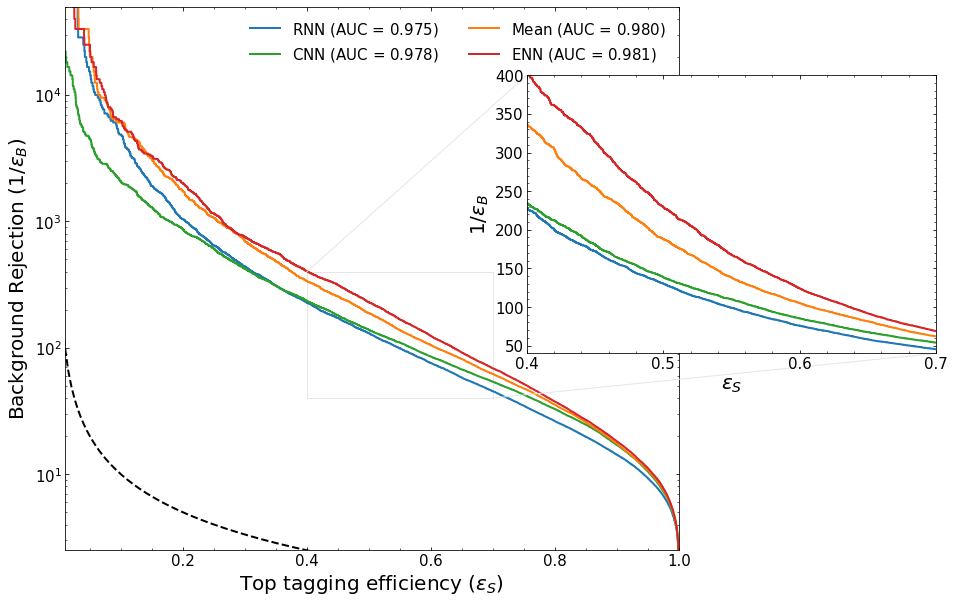

In [28]:
fig = plt.figure(figsize=(11, 10), facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

to_plot = [
           (tpr_rnn, fpr_rnn, auc_rnn,    'RNN', 'tab:blue'),
           (tpr_cnn, fpr_cnn, auc_cnn,    'CNN', 'tab:green'),
           (tpr_mean, fpr_mean, auc_mean, 'Mean','tab:orange'),
           (tpr_enn,  fpr_enn, auc_enn,   'ENN', 'tab:red')
           ]

axins = zoomed_inset_axes(ax, 2.2,bbox_to_anchor=(975,570))
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=".9",capstyle='round')

for tpr, fpr, auc, name, color in to_plot:
    
    ax.plot(tpr,np.where(fpr>0.,1./fpr,1./min([x for x in fpr if x>0])),
             lw=2, label=name+' (AUC = ${:.3f}'.format(auc)+'$)',
             color=color) 

    axins.plot(tpr,np.where(fpr>0.,1./fpr,1./min([x for x in fpr if x>0])),
             lw=2, color=color) 


#axins.set_xlim(.5, .8) 
#axins.set_ylim(20, 230)
axins.set_xlim(.4, .7) 
axins.set_ylim(40, 400)
#axins.set_xticks([0.5,0.6,0.7,0.8])
axins.set_xticks([0.4,0.5,0.6,.7])
axins.set_xlabel('$\epsilon_S$')
axins.set_ylabel('$1/\epsilon_B$')

x = np.linspace(min([x for x in fpr_mean if x>0]),1.,200)
ax.plot(x, 1./x, 'k--', lw=2)

#ax.plot([0.5,.5],[5,3e2],linestyle='dashed',color='darkred',zorder=0)
#ax.plot([0.8,.8],[1.8e1,3e3],linestyle='dashed',color='darkred',zorder=0)

#plt.text(0.51,1.2e1,'$\epsilon_S = 0.5$',fontsize=15,color='darkred',rotation=90)
#ax.text(0.28,8e1,  r'$1/\epsilon^{ENN}_B'+' = {:.0f}$'.format(enn_mean5),fontsize=15,color='darkred')
#ax.text(0.27,3.25e1,  r'$1/\epsilon^{Mean}_B'+' = {:.0f}$'.format(ave_mean5),fontsize=15,color='darkred')
#ax.text(0.28,1.2e1,  r'$1/\epsilon^{CNN}_B'+' = {:.0f}$'.format(cnn_mean5),fontsize=15,color='darkred')
#ax.text(0.28,5,r'$1/\epsilon^{RNN}_B'+' = {:.0f}$'.format(rnn_mean5),fontsize=15,color='darkred')

#plt.text(0.81,2e2,'$\epsilon_S = 0.8$',fontsize=15,color='darkred',rotation=90)
#ax.text(0.6,2e3,  r'$1/\epsilon^{ENN}_B'+' = {:.0f}$'.format(enn_mean8),fontsize=15,color='darkred')
#ax.text(0.59,8e2,  r'$1/\epsilon^{Mean}_B'+' = {:.0f}$'.format(ave_mean8),fontsize=15,color='darkred')
#ax.text(0.6,2.2e1*10+100,  r'$1/\epsilon^{CNN}_B'+' = {:.0f}$'.format(cnn_mean8),fontsize=15,color='darkred')
#ax.text(0.6,1.5e2,r'$1/\epsilon^{RNN}_B'+' = {:.0f}$'.format(rnn_mean8),fontsize=15,color='darkred')



ax.set_yscale('log')
ax.set_ylabel('Background Rejection ($1/\epsilon_B$)',fontsize=20)
ax.set_xlabel('Top tagging efficiency ($\epsilon_S$)',fontsize=20)
leg = ax.legend(loc='best',fontsize=15,ncol=2)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax.set_ylim([2.5,5e4])
ax.set_xlim([0.01,1])
#all_auc = np.array([item for key, item in roc_dict.items() if 'auc' in key])
#plt.title(r"AUC = $ {:.4f} \pm {:.4f}$".format(all_auc.mean(), all_auc.std()/np.sqrt(float(len(all_auc))) ))
plt.savefig('roc.png',bbox_inches = 'tight')
plt.show()

# Analysing Bayesian Ensemble Neural Network Results

In [3]:
main_path = 'EnsembleNN/'
from TopTagger.Models.simpleBRNN import BayesModel as BRNN
from TopTagger.Models.simpleBCNN     import BayesModel as BCNN
from TopTagger.Models.simpleBENN import BayesModel as BENN
from TopTagger.Models.simpleBENNv2 import BayesModel as BENNv2

model_rnn = BRNN(1.)
model_rnn.load_weights(main_path+'output/lstm/simpleBRNN_0/simplebrnn_model.h5')
model_cnn = BCNN(1.)
model_cnn.load_weights(main_path+'output/covnet/simpleBCNN_0/simplebcnn_model.h5')
model_enn = BENN(1.)
model_enn.load_weights(main_path+'output/enn/simpleBENN_0/simplebenn_model.h5')
model_enn2 = BENNv2(1.)
model_enn2.load_weights(main_path+'output/enn/simpleBENN_1/simplebenn_model.h5')

Instructions for updating:
Please use `layer.add_weight` method instead.


In [4]:
from TopTagger.system.feedback import progress

N = 100

test.Reset()
test.shuffle    = False
test.batch_size = 100000

X_test, y_test = test[0]
for ix in range(N):
    progress(ix, N-1)
    yhat_rnn_tmp = model_rnn(X_test[1], training=False)
    yhat_cnn_tmp = model_cnn(X_test[0], training=False)
    yhat_enn_tmp = model_enn(X_test,    training=False)
    yhat_enn2_tmp= model_enn2(X_test,    training=False)
    
    
    if ix == 0:
        yhat_rnn  = yhat_rnn_tmp
        yhat_cnn  = yhat_cnn_tmp
        yhat_mean = np.hstack((yhat_rnn_tmp, yhat_cnn_tmp)).mean(axis=1).reshape(yhat_cnn_tmp.shape)
        yhat_enn  = yhat_enn_tmp
        yhat_enn2 = yhat_enn2_tmp
    else:
        yhat_rnn  = np.hstack((yhat_rnn,  yhat_rnn_tmp))
        yhat_cnn  = np.hstack((yhat_cnn,  yhat_cnn_tmp))
        yhat_mean = np.hstack((yhat_mean, np.hstack((yhat_rnn_tmp, yhat_cnn_tmp)).mean(axis=1).reshape(yhat_cnn_tmp.shape)))
        yhat_enn  = np.hstack((yhat_enn,  yhat_enn_tmp))
        yhat_enn2 = np.hstack((yhat_enn2,  yhat_enn2_tmp))

test.Reset()
del X_test, y_test

In [5]:
from scipy.optimize import curve_fit

def plot_mu_sig(yhat,text=[],save=''):
    aleatoric = (yhat * (1.-yhat)).mean(axis=1)
    epistemic = (yhat**2).mean(axis=1) - (yhat.mean(axis=1))**2

    f = lambda x,a,b,c : a*x**2 + b*x + c
    popt, _ = curve_fit(f, yhat.mean(axis=1),yhat.std(axis=1))
    a, b, c = popt
    
    fig  = plt.figure(figsize=(10, 7))
    sc   = plt.scatter(yhat.mean(axis=1),yhat.std(axis=1),c=aleatoric+epistemic,s=5,cmap='jet',vmin=0,vmax=(aleatoric+epistemic).max(),marker='.')
    cbar = plt.colorbar(sc)
    cbar.set_label('Total Uncertainty',fontsize=20)
    x_line = np.arange(0, 1, .01)
    y_line = f(x_line, a, b,c )
    plt.plot(x_line,y_line,color='k',lw=2,linestyle='dashed')
    plt.xlim([0.-.01,1.01])
    plt.ylim([0.,yhat.std(axis=1).max()])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('$\hat{\sigma}_{bayes}$')
    if text != []:
        plt.text(text[0],yhat.std(axis=1).max()+text[1],text[2],color='darkred',fontsize=15)
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()
    

def plot_epistemic_aleatoric(yhat,text=[],save=''):
    aleatoric = (yhat * (1.-yhat)).mean(axis=1)
    epistemic = (yhat**2).mean(axis=1) - (yhat.mean(axis=1))**2
    
    f = lambda x,a,b,c : a*x**2 + b*x + c
    popt, _ = curve_fit(f, yhat.mean(axis=1),epistemic)
    a, b, c = popt
    
    fig  = plt.figure(figsize=(10, 7))
    sc = plt.scatter(yhat.mean(axis=1),epistemic,c=aleatoric,s=5,cmap='jet',vmin=0,vmax=aleatoric.max(),marker='.')
    cbar = plt.colorbar(sc)
    cbar.set_label('Aleatoric Uncertainty',fontsize=20)
    
    x_line = np.arange(0, 1, .01)
    y_line = f(x_line, a, b,c )
    plt.plot(x_line,y_line,color='k',lw=2,linestyle='dashed')
    
    plt.xlim([0.-0.01,1.01])
    plt.ylim([1e-8,epistemic.max()])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('Epistemic Uncertainty')
    plt.yscale('log')
    if text != []:
        plt.text(text[0],epistemic.max()+text[1],text[2],color='darkred',fontsize=15)
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()
    
def plot_compare_std(rnn,cnn,mean,enn):
    f = lambda x,a,b,c : a*x**2 + b*x + c

    fig  = plt.figure(figsize=(8, 7))
    
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN')]:
 
        popt, pcov = curve_fit(f, yhat.mean(axis=1),yhat.std(axis=1))
        perr = np.sqrt(np.diag(pcov))

        err_up = popt+2.*perr
        err_dn = popt-2.*perr
        x_line = np.arange(0., 1., .01)
        plt.plot(x_line,f(x_line, *popt),color=color,lw=2,linestyle='solid',label=label)
        #plt.fill_between(x_line,f(x_line, *err_up),f(x_line, *err_dn),color=color,alpha=0.1,lw=0)
    
    leg = plt.legend(loc='upper right',fontsize=15)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.xlim([0,1])
    #plt.ylim([0,0.06])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('$\hat{\sigma}_{bayes}$')
    plt.show()

def plot_compare_epistemic(rnn,cnn,mean,enn):
    f = lambda x,a,b,c : a*x**2 + b*x + c

    fig  = plt.figure(figsize=(8, 7))
    
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN')]:
        
        epistemic = (yhat**2).mean(axis=1) - (yhat.mean(axis=1))**2
        popt, pcov = curve_fit(f, yhat.mean(axis=1),epistemic)
        perr = np.sqrt(np.diag(pcov))

        err_up = popt+2.*perr
        err_dn = popt-2.*perr
        x_line = np.arange(0., 1., .01)
        plt.plot(x_line,f(x_line, *popt),color=color,lw=2,linestyle='solid',label=label)
        #plt.fill_between(x_line,f(x_line, *err_up),f(x_line, *err_dn),color=color,alpha=0.1,lw=0)
    
    leg = plt.legend(loc='upper right',fontsize=15)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.xlim([0,1])
    #plt.ylim([0,.004])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('Epistemic Uncertainty')
    plt.show()
    
def plot_compare_aleatoric(rnn,cnn,mean,enn,save=''):
    f = lambda x,a,b,c : a*x**2 + b*x + c

    fig  = plt.figure(figsize=(8, 7))
    
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN')]:
        
        aleatoric = (yhat * (1.-yhat)).mean(axis=1)
        popt, pcov = curve_fit(f, yhat.mean(axis=1),aleatoric)
        perr = np.sqrt(np.diag(pcov))

        err_up = popt+2.*perr
        err_dn = popt-2.*perr
        x_line = np.arange(0., 1., .01)
        plt.plot(x_line,f(x_line, *popt),color=color,lw=2,linestyle='solid',label=label)
        #plt.fill_between(x_line,f(x_line, *err_up),f(x_line, *err_dn),color=color,alpha=0.1,lw=0)


    leg = plt.legend(loc='upper right',fontsize=15)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.xlim([0.4,.6])
    plt.ylim([0.24,.26])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('Aleatoric Uncertainty')
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

def plot_scatter_epistemic(rnn,cnn,mean,enn,save=''):
    fig  = plt.figure(figsize=(8, 7))
    epsmax = 0.
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             #(mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN')]:
        
        epistemic = (yhat**2).mean(axis=1) - (yhat.mean(axis=1))**2
        if epistemic.max() > epsmax:
            epsmax = epistemic.max()
        plt.scatter(yhat.mean(axis=1),epistemic,color=color,s=7,label=label,alpha=0.1,marker='.')
    
    #leg = plt.legend(loc='best',fontsize=15,ncol=2)
    #leg.get_frame().set_alpha(0.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.set_zorder(100)
    #plt.yscale('log')
    plt.xlim([0,1])
    plt.ylim([0,4e-5])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('Epistemic Uncertainty')
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

def plot_scatter_std(rnn,cnn,mean,enn,save=''):
    fig  = plt.figure(figsize=(8, 7))
    stdmax = 0.
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             #(mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN')]:
        
        if yhat.std(axis=1).max() > stdmax:
            stdmax = yhat.std(axis=1).max()
        plt.scatter(yhat.mean(axis=1),yhat.std(axis=1),color=color,s=7,label=label,alpha=0.1,marker='.')
    
    #leg = plt.legend(loc='best',fontsize=15,ncol=2)
    #leg.get_frame().set_alpha(0.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.set_zorder(100)
    #plt.yscale('log')
    plt.xlim([0,1])
    plt.ylim([0,0.0075])
    plt.xlabel('$\hat{\mu}_{bayes}$')
    plt.ylabel('$\hat{\sigma}_{bayes}$')
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()
    
def plot_scatter_entropy(rnn,cnn,mean,enn,save='',txt=''):
    entropy = lambda x, y : - (x * np.log2(x) + y * np.log2(y))
    
    fig  = plt.figure(figsize=(8, 7))
    stdmax = 0.
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN')]:
        
        class0 = 1.-yhat
        class1 = yhat
        for ix in range(yhat.shape[1]):
            if ix == 0:
                ent = entropy(class0[:,ix].reshape((yhat.shape[0],1)),class1[:,ix].reshape((yhat.shape[0],1)))
            else:
                ent = np.hstack((ent,entropy(class0[:,ix].reshape((yhat.shape[0],1)),class1[:,ix].reshape((yhat.shape[0],1)))))
        if ent.mean(axis=1).max() > stdmax :
            stdmax = ent.mean(axis=1).max()
        if (label!='Mean'):plt.scatter(ent.mean(axis=1),ent.std(axis=1),color=color,s=5,label=label,alpha=0.2,marker='.')
        print(label+r' & {:.2%} & {:.2%} \\'.format(float(ent.mean(axis=1)[ent.mean(axis=1) < 0.5].size)/float(ent.mean(axis=1).size),
                                                                        float(ent.mean(axis=1)[ent.mean(axis=1) >= 0.5].size)/float(ent.mean(axis=1).size)))
        
              
    
    #leg = plt.legend(loc='best',fontsize=15,ncol=2)
    #leg.get_frame().set_alpha(0.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.set_zorder(100)
    #plt.yscale('log')
    plt.xlim([0,1])
    plt.ylim([0,0.025])
    plt.xlabel(r'$\hat{\mu}_{\mathcal{S}}$')
    plt.ylabel(r'$\hat{\sigma}_{\mathcal{S}}$')
    if txt != '':
        plt.text(0.05,0.0253,txt,color='darkred',fontsize=15)
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

def hist_mean_entropy(rnn,cnn,mean,enn,enn2,save=''):
    entropy = lambda x, y : - (x * np.log2(x) + y * np.log2(y))
    fig  = plt.figure(figsize=(8, 7))
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN with 1 layer'),(enn2,'tab:purple','ENN with 2 layers')]:
        
        class0 = 1.-yhat
        class1 = yhat
        for ix in range(yhat.shape[1]):
            if ix == 0:
                ent = entropy(class0[:,ix].reshape((yhat.shape[0],1)),class1[:,ix].reshape((yhat.shape[0],1)))
            else:
                ent = np.hstack((ent,entropy(class0[:,ix].reshape((yhat.shape[0],1)),class1[:,ix].reshape((yhat.shape[0],1)))))
        ls = 'solid'
        if label in ['Mean','ENN with 1 layer','ENN with 2 layers']:
            ls = 'dashed'
        #print(ent.mean(axis=1).max())
        plt.hist(ent.mean(axis=1),bins=np.linspace(0.,1.,21),
                label=label, histtype="step", rwidth=1.0,
                 weights=np.ones(ent.mean(axis=1).shape[0])/float(ent.mean(axis=1).shape[0]),
                color=None, edgecolor=color, linewidth=2., linestyle=ls,
                bottom=None, cumulative=False, density=False, align="mid", orientation="vertical")
    
    leg = plt.legend(loc='best',fontsize=15,ncol=2)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.yscale('log')
    plt.xlim([0,1])
    plt.ylim([1e-2,1])
    plt.xlabel(r'$\hat{\mu}_{\mathcal{S}}$')
    plt.ylabel('Normalised number of events')
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

def hist_std_bayes(rnn,cnn,mean,enn,enn2,save=''):
    fig  = plt.figure(figsize=(8, 7))
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN with 1 layer'),(enn2,'tab:purple','ENN with 2 layers')]:
        
        ls = 'solid'
        if label in ['Mean','ENN with 1 layer','ENN with 2 layers']:
            ls = 'dashed'
        #print(ent.mean(axis=1).max())
        plt.hist(yhat.std(axis=1),bins=np.linspace(0.,.01,21),
                label=label, histtype="step", rwidth=1.0,
                 weights=np.ones(yhat.std(axis=1).shape[0])/float(yhat.std(axis=1).shape[0]),
                color=None, edgecolor=color, linewidth=2., linestyle=ls,
                bottom=None, cumulative=False, density=False, align="mid", orientation="vertical")
    
    leg = plt.legend(loc='best',fontsize=15,ncol=2)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.yscale('log')
    plt.xlim([0,.01])
    plt.ylim([1e-5,5])
    plt.xlabel(r'$\hat{\sigma}_{bayes}$')
    plt.ylabel('Normalised number of events')
    plt.xticks([0,0.002,0.004,0.006,0.008,0.01],[0,0.002,0.004,0.006,0.008,0.01])
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

def hist_epistemic(rnn,cnn,mean,enn,enn2,save=''):
    entropy = lambda x, y : - (x * np.log2(x) + y * np.log2(y))
    fig  = plt.figure(figsize=(8, 7))
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN with 1 layer'),(enn2,'tab:purple','ENN with 2 layers')]:
        epistemic = (yhat**2).mean(axis=1) - (yhat.mean(axis=1))**2
        ls = 'solid'
        if label in ['Mean','ENN with 1 layer','ENN with 2 layers']:
            ls = 'dashed'
        #print(ent.mean(axis=1).max())
        plt.hist(epistemic,bins=np.linspace(0.,5e-5,26),
                label=label, histtype="step", rwidth=1.0,
                 weights=np.ones(epistemic.shape[0])/float(epistemic.shape[0]),
                color=None, edgecolor=color, linewidth=2., linestyle=ls,
                bottom=None, cumulative=False, density=False, align="mid", orientation="vertical")
    
    leg = plt.legend(loc='best',fontsize=15,ncol=2)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.yscale('log')
    plt.xlim([0,5e-5])
    plt.ylim([1e-5,1])
    plt.xlabel(r'Epistemic Uncertainty')
    plt.ylabel('Normalised number of events')
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

def hist_aleatoric(rnn,cnn,mean,enn,enn2,save=''):
    fig  = plt.figure(figsize=(8, 7))
    for yhat,color,label in [(rnn,'tab:blue','RNN'),
                             (cnn,'tab:green','CNN'),
                             (mean,'tab:orange','Mean'),
                             (enn,'tab:red','ENN with 1 layer'),(enn2,'tab:purple','ENN with 2 layers')]:
        aleatoric = (yhat * (1.-yhat)).mean(axis=1)
        ls = 'solid'
        if label in ['Mean','ENN with 1 layer','ENN with 2 layers']:
            ls = 'dashed'
        plt.hist(aleatoric,bins=np.linspace(0.,.25,21),
                label=label, histtype="step", rwidth=1.0,
                 weights=np.ones(aleatoric.shape[0])/float(aleatoric.shape[0]),
                color=None, edgecolor=color, linewidth=2., linestyle=ls,
                bottom=None, cumulative=False, density=False, align="mid", orientation="vertical")
    
    leg = plt.legend(loc='best',fontsize=15,ncol=2)
    leg.get_frame().set_alpha(0.5)
    leg.get_frame().set_linewidth(0.0)
    leg.set_zorder(100)
    plt.yscale('log')
    plt.xlim([0,.25])
    plt.ylim([1e-2,1])
    plt.xlabel(r'Aleatoric Uncertainty')
    plt.ylabel('Normalised number of events')
    if save!='':
        plt.savefig(save,bbox_inches = 'tight')
    plt.show()

RNN & 71.91% & 28.09% \\
CNN & 75.21% & 24.79% \\
Mean & 72.60% & 27.40% \\
ENN & 78.05% & 21.95% \\


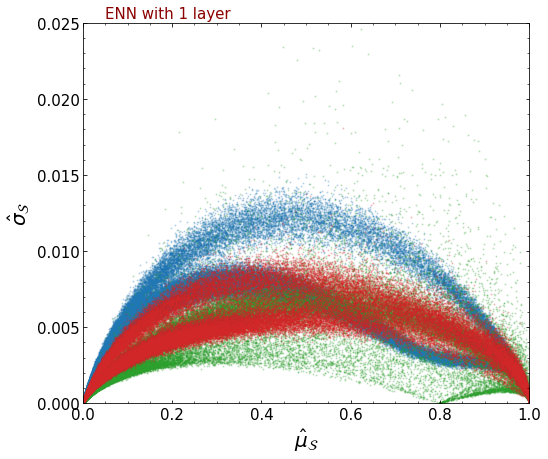

In [56]:
plot_scatter_entropy(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn,save='entropy.png',txt='ENN with 1 layer')

RNN & 71.91% & 28.09% \\
CNN & 75.21% & 24.79% \\
Mean & 72.60% & 27.40% \\
ENN & 79.55% & 20.45% \\


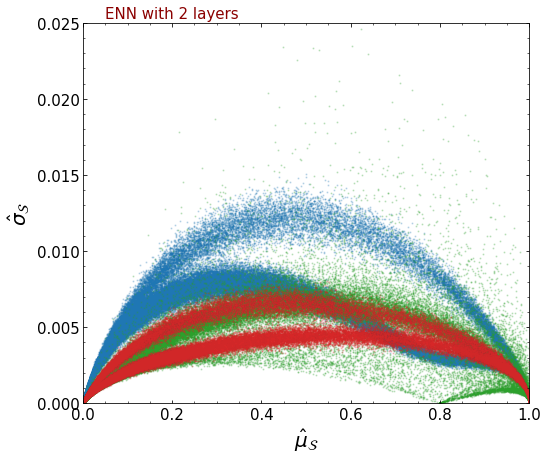

In [57]:
plot_scatter_entropy(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn2,save='entropy2.png',txt='ENN with 2 layers')

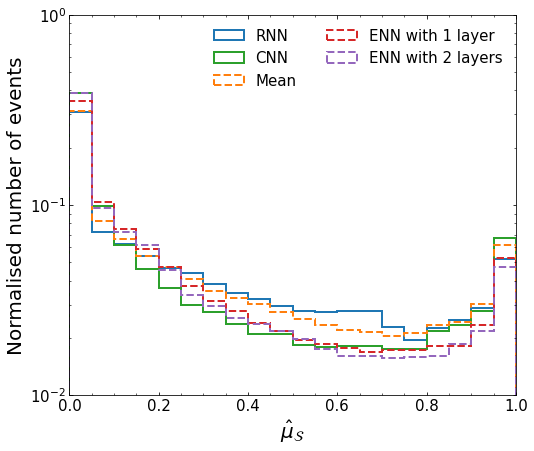

In [15]:
hist_mean_entropy(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn,yhat_enn2,save='entropy_hist.png')

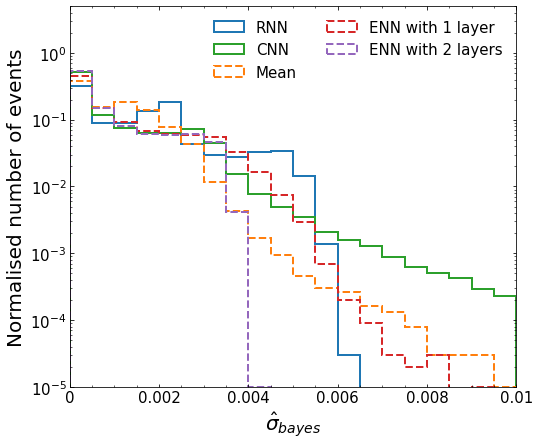

In [52]:
hist_std_bayes(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn,yhat_enn2,save='std_bayes_hist.png')

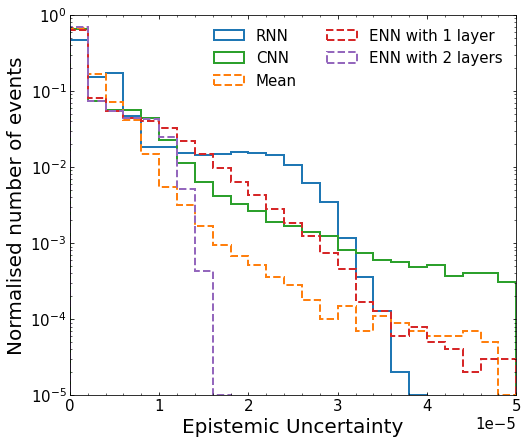

In [34]:
hist_epistemic(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn,yhat_enn2,save='epistemic_hist.png')

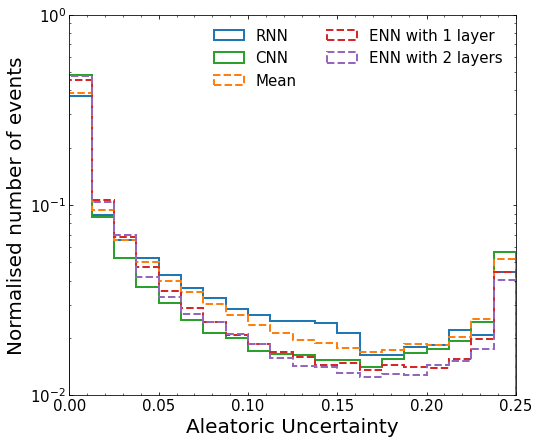

In [6]:
hist_aleatoric(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn,yhat_enn2,save='aleatoric_hist.png')

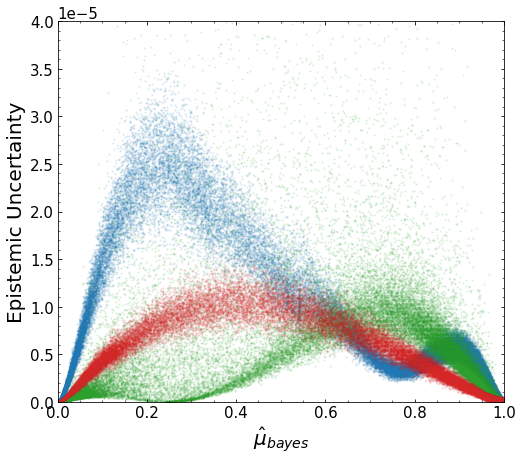

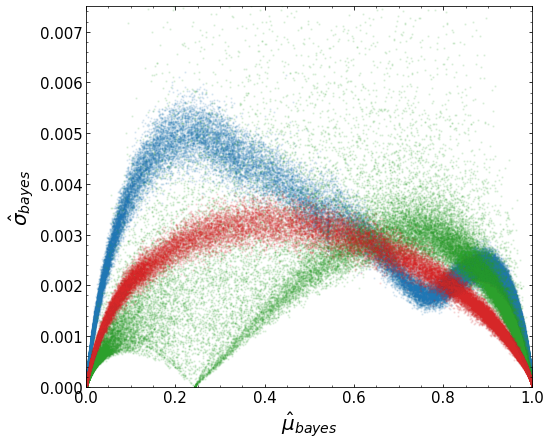

In [18]:
plot_scatter_epistemic(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn2,save='epistemic.png')
plot_scatter_std(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn2,save='mean_std.png')

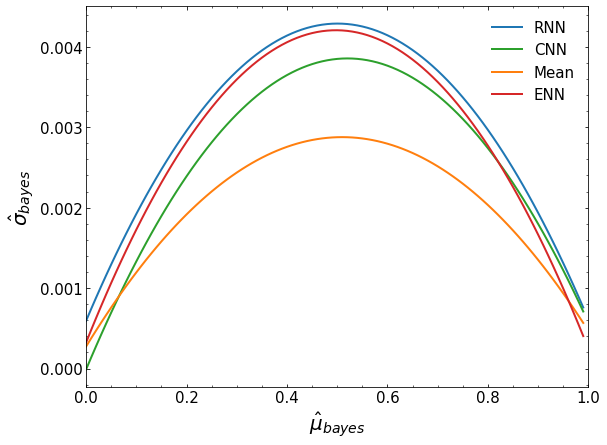

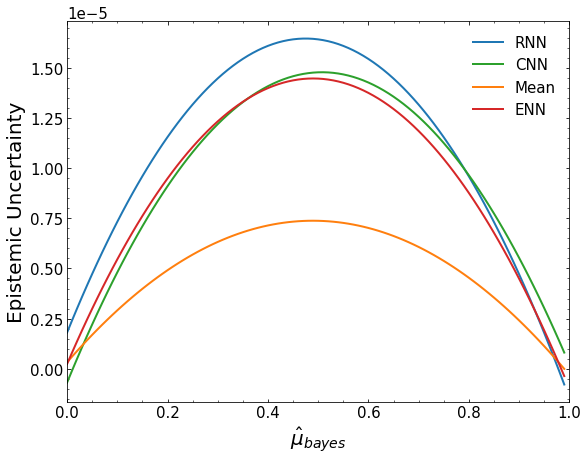

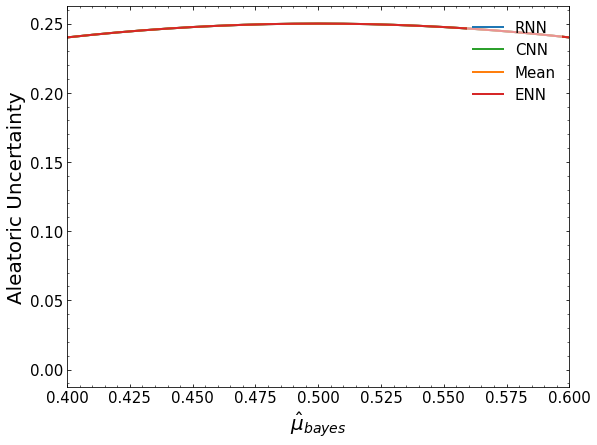

In [55]:
plot_compare_std(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn)
plot_compare_epistemic(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn)
plot_compare_aleatoric(yhat_rnn,yhat_cnn,yhat_mean,yhat_enn)

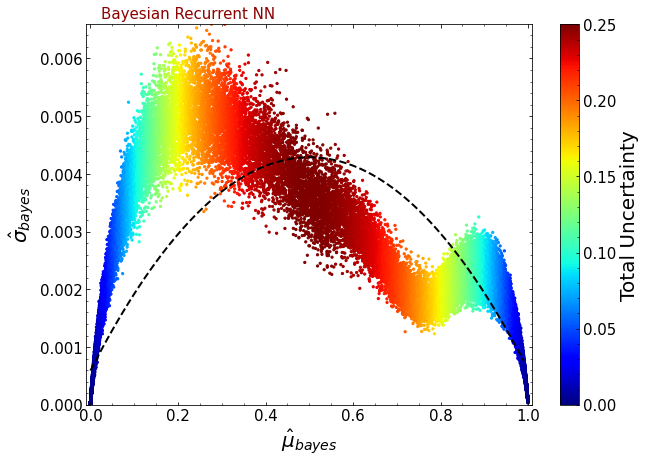

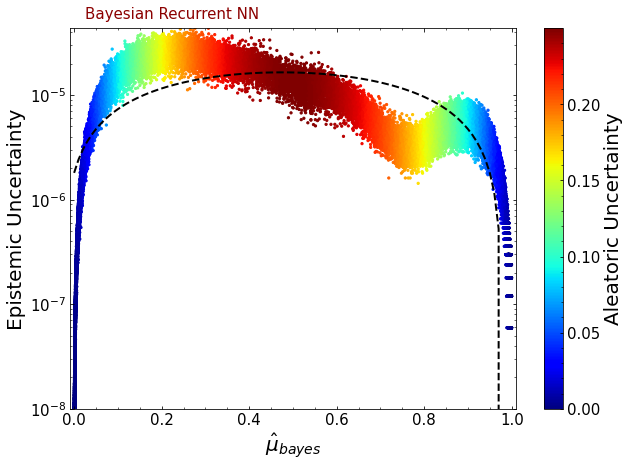

In [19]:
plot_mu_sig(yhat_rnn,[0.025,1e-4,'Bayesian Recurrent NN'],save='RNN_mu_sig.png')
plot_epistemic_aleatoric(yhat_rnn,[0.025,1e-5,'Bayesian Recurrent NN'],save='RNN_eps_ale.png')

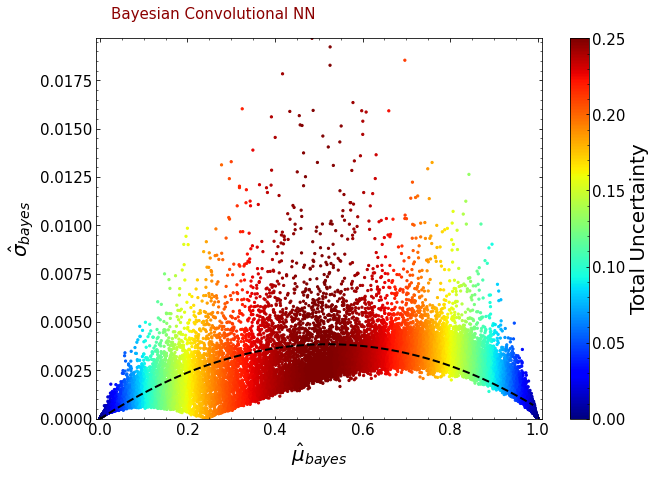

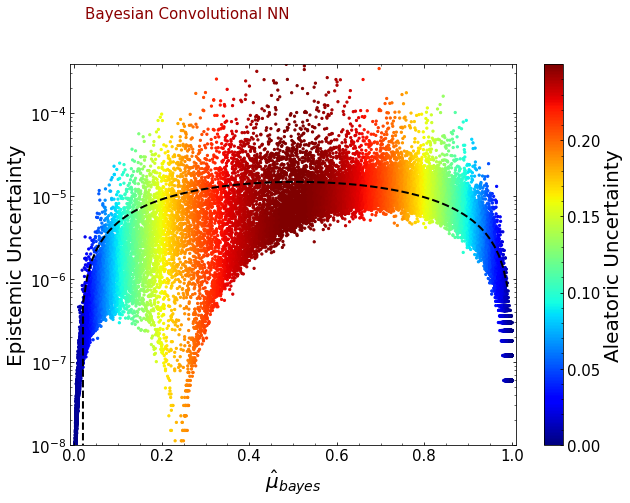

In [8]:
plot_mu_sig(yhat_cnn,[0.025,yhat_cnn.std(axis=1).max()+1e-3,'Bayesian Convolutional NN'])
plot_epistemic_aleatoric(yhat_cnn,[0.025,yhat_cnn.std(axis=1).max()+1e-3,'Bayesian Convolutional NN'])

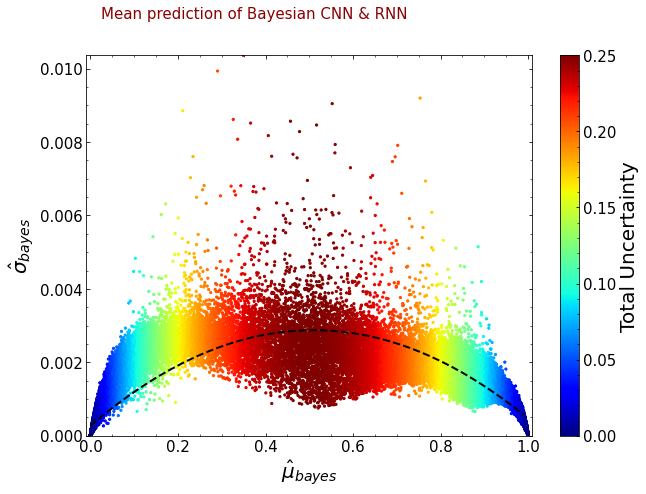

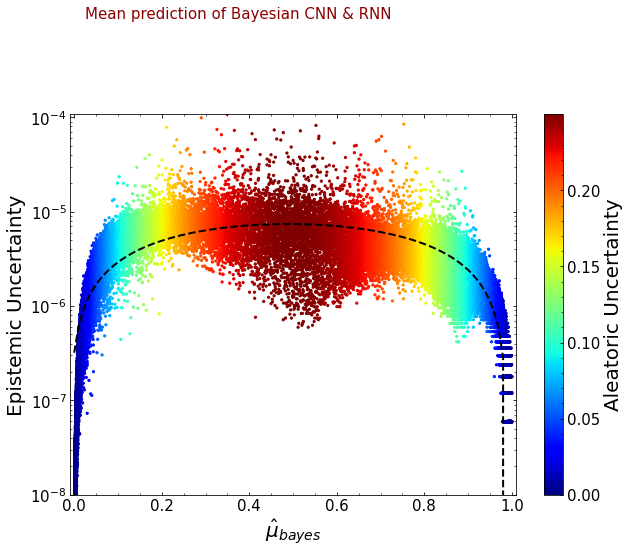

In [9]:
plot_mu_sig(yhat_mean,[0.025,yhat_mean.std(axis=1).max()+1e-3,'Mean prediction of Bayesian CNN & RNN'])
plot_epistemic_aleatoric(yhat_mean,[0.025,yhat_mean.std(axis=1).max()+1e-3,'Mean prediction of Bayesian CNN & RNN'])

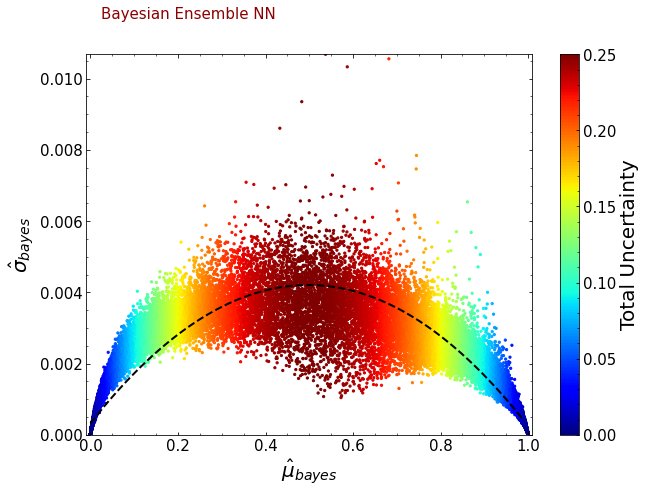

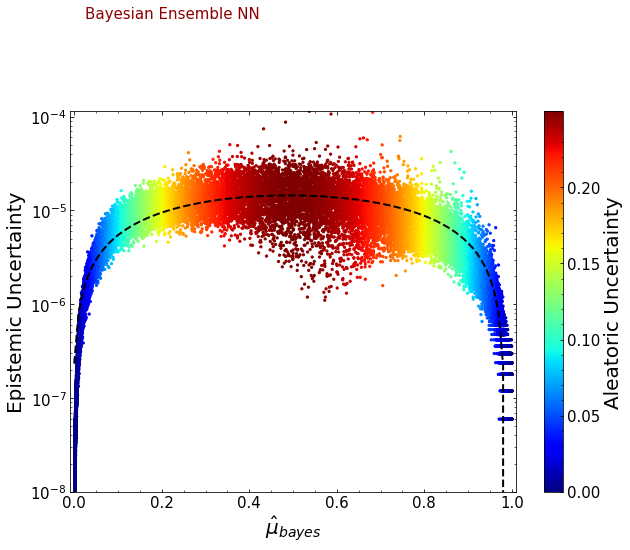

In [10]:
plot_mu_sig(yhat_enn,[0.025,yhat_enn.std(axis=1).max()+1e-3,'Bayesian Ensemble NN'])
plot_epistemic_aleatoric(yhat_enn,[0.025,yhat_enn.std(axis=1).max()+1e-3,'Bayesian Ensemble NN'])